
## Harmonic oscillator

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min  T, \\[0.5em]
        \dot{x}_1(t) = x_2(t), \; t\in [0,T]\\[0.5em]
        \dot{x}_2(t) = u(t)-x_1(t), t\in [0,T]  \\[0.5em]
        u(t) \in [-1, 1], \; t\in [0,T]\\[0.5em]
        x(0) = (2,2) , \quad x(T) = 0_{\mathrm{R}^2}, 
    \end{array}
    \right.
$$


In [19]:
using JuMP  
using Ipopt
using Plots
using Plots.PlotMeasures

In [20]:
mutable struct DirectS
    t; x1; x2 ; x3 ; u
end
mutable struct DirectSolution
    t; x1; x2 ; λ ; u ; xu ; xv
end

In [25]:
function HO(x0, ε; solution=[], nsteps=400, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)
    
    N  = nsteps     # Grid size
    
    @variables(sys, begin
                x1[1:N+1]    
                x2[1:N+1]   
        -1.0  ≤  λ[1:N+1] ≤ 1.0
        -1.0  ≤  u[1:N+1] ≤ 1.0
         #0.0  ≤ Δt        ≤ 1.0 
        -1e1 ≤ v[1:N+1]  ≤ 1e1 
         -1e1  ≤ xv[1:N+1]
         -1e1  ≤ xu[1:N+1]
    end)
    
   #set_start_value(Δt, 10/N);
    for i in 1:N+1
        set_start_value(λ[i], 0.8);
        set_start_value(v[i], 0.0);
        set_start_value(xv[i], 0.0);
        set_start_value(xu[i], 0.0);
        set_start_value(u[i], 0.5);
    end
    
#    T = Δt*(N+1) ;
    T = 10.0
    Δt = T/(N+1)
    
    # Objective
    @objective(sys, Min, ε*xv[N+1]+xu[N+1])

    # Boundary constraints
    @constraints(sys, begin
        con_xu0, xu[1]   == 0.0
        con_xv0, xv[1]   == 0.0
        con_x10, x1[1]   == x0[1] 
        con_x20, x2[1]   == x0[2] 
        con_x1f, x1[N+1] == 0.0 
        con_x2f, x2[N+1] == -1e-8
    end)

    # Dynamics
    @NLexpression(sys, dx1[j = 1:N+1], x2[j])
    @NLexpression(sys, dx2[j = 1:N+1], ifelse(x2[j] > 0. , u[j] - x1[j], λ[j] - x1[j] ) )
    @NLexpression(sys,  dλ[j = 1:N+1], ifelse(x2[j] > 0. , v[j], 0. ) )
    @NLexpression(sys, dxv[j = 1:N+1], v[j]^2)
#    @NLexpression(sys, dxu[j = 1:N+1], ifelse(x2[j] > 0. , 0., u[j]^2 ))
    @NLexpression(sys, dxu[j = 1:N+1], u[j]^2 )
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dx3[j=1:N],  λ[j+1] ==  λ[j] + 0.5 * Δt * (dλ[j+1] + dλ[j])
        con_dxv[j=1:N], xv[j+1] == xv[j] + 0.5 * Δt * (dxv[j+1] + dxv[j])
        con_dxu[j=1:N], xu[j+1] == xu[j] + 0.5 * Δt * (dxu[j+1] + dxu[j])
    end)
    
    
    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    λ  = value.(λ)[:]
    u  = value.(u)[:]
    xu  = value.(xu)[:]
    xv  = value.(xv)[:]
    t  = (0:N) * value.(Δt)
    
    return DirectSolution(t, x1, x2, λ, u, xu, xv)
    
    
end;

In [26]:
# Resolution
x0  = [3.0; 0.0]
ε   = 1e-3
sol = HO(x0, ε, nsteps=500);

Solving...
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:    13006
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2000

Total number of variables............................:     3507
                     variables with only lower bounds:     1002
                variables with lower and upper bounds:     1503
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2506
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00

xu = 0.13464884554605075
xv = 0.0842212290351398
[158, 343]
3.13373253493014


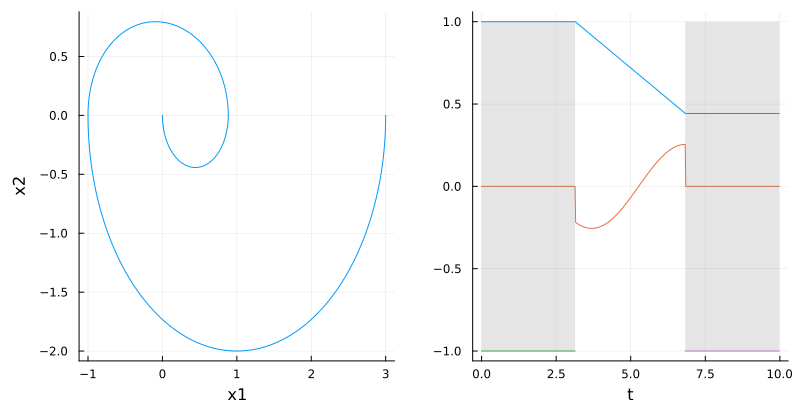

In [27]:
# Plots
t  = sol.t
x1 = sol.x1
x2 = sol.x2
λ = sol.λ
u  = sol.u
xu = sol.xu
xv = sol.xv

println("xu = ", xu[end])
println("xv = ", xv[end])

ind = findall(x2[2:end-2].*x2[1:end-3].<0)
println(ind)
t1 = t[ind[1]]
t2 = t[ind[2]]
println(t1)

#u1 = copy(u) 
#for i in eachindex(u1)
#    if abs(u1[i]) <  0.01
#        u1[i] = x3[1]
#    end
#end

#x1_plot   = plot(t, x1,  xlabel = "t", ylabel = "x1",  legend = false)
#x2_plot   = plot(t, x2,  xlabel = "t", ylabel = "x2",  legend = false)
control_plot = plot(t, λ,  xlabel = "t", label = "λ",  legend = false)
plot!(control_plot, t, u, label="u")
plot!(control_plot, [0.0, t1], [-1.0, -1.0], fillrange = 1.0, fillalpha = 0.2, fillcolor = :gray)
plot!(control_plot, [t2, t[end]], [-1.0, -1.0], fillrange = 1.0, fillalpha = 0.2, fillcolor = :gray)

#u_plot    = plot(t, u,   xlabel = "t", ylabel = "u",   legend = false)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot( x1x2_plot, control_plot, layout = (1,2), size=(800, 400), left_margin=5mm)

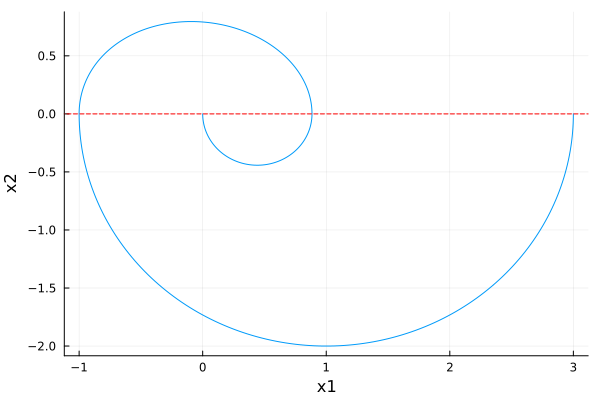

In [24]:
# create the first plot
plot(x1,x2 , xlabel = "x1", ylabel = "x2", legend = false)
#y = [-5, 5]
# add the second plot to the first plot
#plot!(ones(2)*3, y, line=:stem, xlabel="x", ylabel="y", title="interface", xlim=(-10,10))
hline!([0], line=:dash, color=:red)

In [6]:
# Compute the differences between adjacent elements
d = diff(u)

# Find the indices where the differences are non-zero
switchings = findall(abs.(d) .> 0.7)

# Print the result
switching_times = t[switchings] ; 


T  = t[end];

t1  = switching_times[1]
t2  = switching_times[2] ; 

# Indirect method

In [7]:
using NLsolve
using Plots
using Plots.PlotMeasures
include("flow.jl");

In [8]:
# Dynamics
function F0(x)
    return [ x[2], -x[1] ]
end

function F1(x)
    return [ 0.0, 1.0 ]
end

# Hamiltonians: permanent region
H0(x, p) = p' * F0(x)
H1(x, p) = p' * F1(x)

H(x, p, u) = H0(x, p) + u*H1(x,p) # pseudo-Hamiltonian

up(x, p) =  1.0
um(x, p) = -1.0

Hp(x, p) = H(x, p, up(x, p))
Hm(x, p) = H(x, p, um(x, p))

# Flows
fp  = Flow(Hp)
fm  = Flow(Hm);

In [9]:
# Shooting function
function SHOOT(p0, tt1, tt2, TT) 
        
    x1, p1 = fm(t0, x0 , p0, tt1)
    x2, p2 = fp(tt1, x1 , p1, tt2)
    x3, p3 = fm(tt2, x2 , p2, TT)

    s = zeros(eltype(p0), 5)
    
    s[1:2] = x3 - [ 0.0 , 0.0 ]   # target
    
    s[3] = H1(x1, p1)             # switching
    s[4] = H1(x2, p2)             # switching
    s[5] = Hp(x0, p0) - 1.0       # free final time
    

    return s

end;

In [10]:
# Solve
t0 = 0.0
x0 = [2.0; 2.0]
S(ξ) = SHOOT(ξ[1:2], ξ[3], ξ[4], ξ[5]);

In [11]:
ξ_guess = [p1[1] , p2[1], t1, t2, T]; # initial guess

In [12]:
S(ξ_guess);

In [13]:
# Solve

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0 = indirect_sol.zero[1:2]
    tt1 = indirect_sol.zero[3]
    tt2 = indirect_sol.zero[4]
    TT  = indirect_sol.zero[5]

else
    error("Not converged")
end;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.714934e+00              NaN
     1     2.073014e-02     2.755113e+00
     2     2.345183e-04     4.622837e-02
     3     3.358192e-08     2.176971e-04
     4     1.704527e-15     6.097729e-08
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [-0.785230838611897, -0.8555280965841662, 0.8282264006597898, 3.9654476152802056, 5.0195539433926655]
 * Zero: [1.1045786867955638, 1.2091573735911278, 0.8305664776430566, 3.972159131232845, 5.019356682429274]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5


In [14]:
tt1 - t1 

0.00234007698326677

In [15]:
tt2 - t2

0.006711515952639413

In [16]:
TT - T

-0.00019726096339134358

In [17]:
ode_sol = fm((t0, tt1), x0, [p1[1] ; p2[1]], saveat=0.1) ;
ttt1 = ode_sol.t ;
xx1 = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1 = [ ode_sol[3:4, j] for j in 1:size(ttt1, 1) ] ;
uu1 = um.(xx1, pp1)  ;

ode_sol = fp((tt1, tt2), xx1[end], pp1[end], saveat=0.1) ;
ttt2 = ode_sol.t ;
xx2 = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ] ;
pp2 = [ ode_sol[3:4, j] for j in 1:size(ttt2, 1) ] ;
uu2 = up.(xx2, pp2)  ;

ode_sol = fm((tt2, TT), xx2[end], pp2[end], saveat=0.1) ;
ttt3 = ode_sol.t ;
xx3 = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ] ;
pp3 = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] ;
uu3 = um.(xx3, pp3)  ;

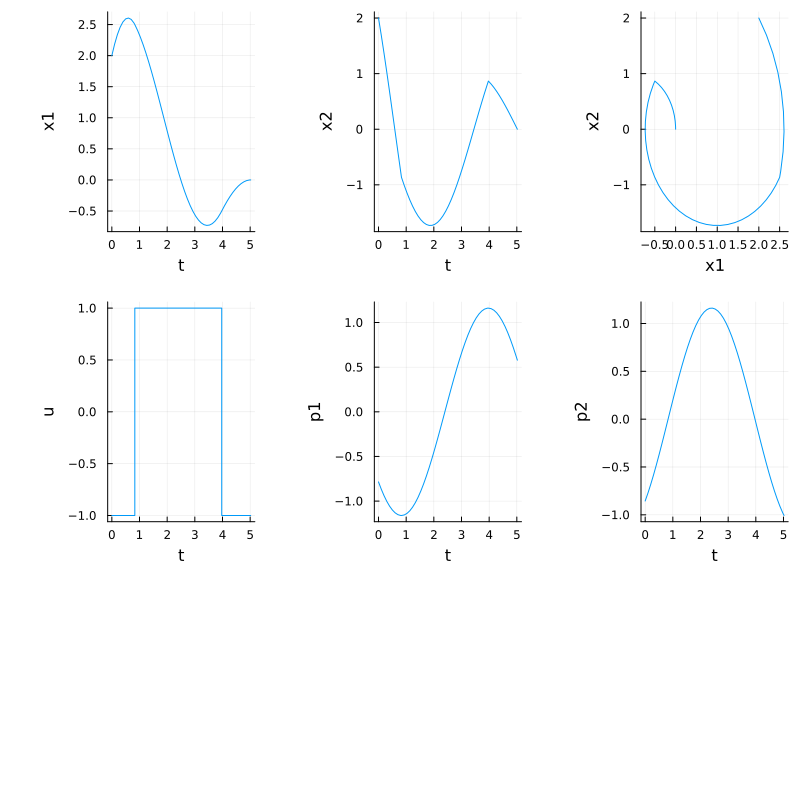

In [18]:
t = [ ttt1 ; ttt2 ; ttt3 ]
x = [ xx1 ; xx2 ; xx3 ]
p = [ pp1 ; pp2 ; pp3 ]
u = [ uu1 ; uu2 ; uu3 ]

m = length(t)

x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  legend = false)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2",  legend = false)
p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", legend = false)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", legend = false)
u_plot    = plot(t,   u, xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot, x1x2_plot, u_plot, p1_plot ,p2_plot , layout = (3,3), size=(800,800), left_margin=10mm)